<a href="https://colab.research.google.com/github/MarioCastilloM/Activos_Derivados/blob/main/Ayudant%C3%ADa_II_Administraci%C3%B3n_de_Carteras_Pauta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ayudantía II Administración de Carteras
+ Nicolás Álvarez
+ Mario Castillo

## Pregunta 1

Considere la función de utilidad de la forma $U(W)=\frac{W^{(1-\tau)}}{1-\tau}$, donde $W$ es la riqueza y $\tau$ es una medida de la aversión al riesgo. Grafique la función de utilidad y evalúe y comente su forma para distintos niveles de $\tau$

In [39]:
def utility(w, tau=0.5):
  u = (w**(1-tau))/(1-tau)
  return u

In [40]:
import numpy as np
riqueza = list(range(1, 141))
utilidad = [utility(w = x) for x in riqueza]

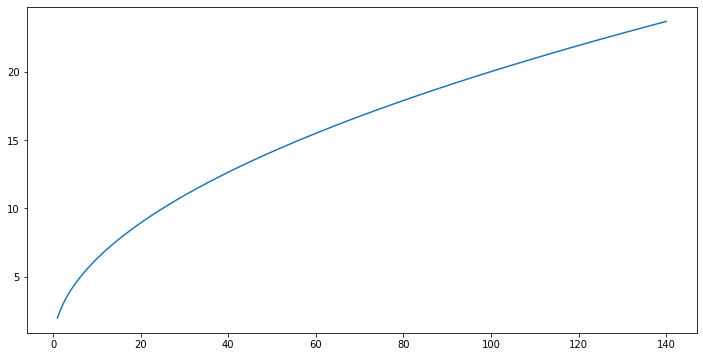

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12, 6))
sns.lineplot(x=riqueza, y=utilidad)

In [42]:
import ipywidgets as widgets
from IPython.display import display

# función para graficar la función de utilidad resultante
def show_utility(tau, w_width=200):
  """
  Draw the results of a utility function given wealth and risk aversion levels
  """
  w_range = range(1, w_width + 1)
  u = [utility(w, tau) for w in w_range]
  plt.figure(figsize = (12, 6))
  sns.lineplot(x=w_range, y=u)

# generamos un panel de control de los parámetros para obtener un gráfico interactivo
utility_controls = widgets.interactive(show_utility,
                                   tau = (-4, 4, 0.1)
                                   )

# desplegamos el panel de control establecido en el paso anterior
display(utility_controls)

interactive(children=(FloatSlider(value=0.0, description='tau', max=4.0, min=-4.0), IntSlider(value=200, descr…

## Pregunta 2

Seleccione dos series de precios de activos, calcule sus retornos y grafique la frontera eficiente, el portafolio óptimo y la Capital Allocation Line

In [43]:
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime

stocklist = ['NOVA','PLUG']

start = '2019-07-18'
end = '2022-07-18'

p = web.DataReader(stocklist, 'yahoo', start, end)

prices = p['Adj Close']

returns = prices.pct_change().dropna()

In [45]:
returns.shape

(750, 2)

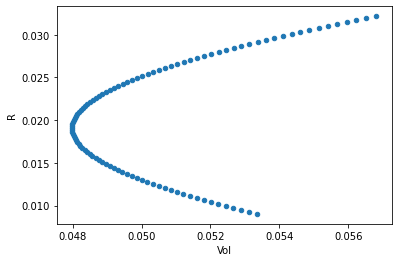

In [46]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

returns_ann = annualize_rets(returns, 12)
n_points = 100
weights = [np.array([w, 1 - w]) for w in np.linspace(0, 1, n_points)]
cov = returns.cov()
rets = [portfolio_return(w, returns_ann) for w in weights]
vol = [portfolio_vol(w, cov) for w in weights]
ef = pd.DataFrame({
    "R": rets,
    "Vol": vol
})
ef.plot.scatter(x = "Vol", y = "R")

In [47]:
from scipy.optimize import minimize
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

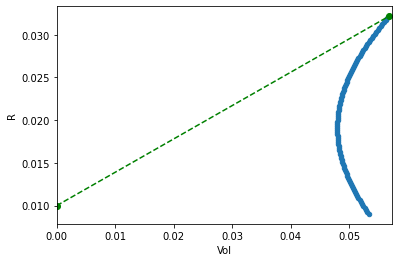

In [48]:
ax = ef.plot.scatter(x = "Vol", y = "R")
ax.set_xlim(left = 0)
rf = 0.01
w_msr = msr(rf, returns_ann, cov)
r_msr = portfolio_return(w_msr, returns_ann)
vol_msr = portfolio_vol(w_msr, cov)
# Add CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker = 'o', linestyle = "dashed")

## Pregunta 3

Considere los sets de datos "brka_d_ret.csv" y "F-F_Research_Data_Factors_m.csv", los que contienen información acerca de los retornos de BlackRock y los factores $Mkt-RF$, $SMB$, $HML$ y $RF$.

+ Descomponga los retornos de BRKA en la porción que corresponde al mercado y el resto que no es explica por el mercado usando el CAPM como modelo explicativo

$$ R_{brka,t} - R_{f,t} = \alpha + \beta(R_{mkt,t} - R_{f,t}) + \epsilon_t $$

In [49]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Cursos/Investment Management with ML/data/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [50]:
fff = pd.read_csv(path + 'F-F_Research_Data_Factors_m.csv', parse_dates=True,  index_col=0)
brka_d = pd.read_csv(path + 'brka_d_ret.csv', parse_dates=True, index_col=0)

In [51]:
def compound(r):
  """
  returns the result of compounding the set of returns in r
  """
  return np.expm1(np.log1p(r).sum())

In [52]:
brka_m = brka_d.resample('M').apply(compound).to_period('M')
brka_m.head()

,BRKA
DATE,
1990-01,-0.140634
1990-02,-0.030852
1990-03,-0.069204
1990-04,-0.003717
1990-05,0.067164


In [53]:
fff.head()

,Mkt-RF,SMB,HML,RF
192607,2.96,-2.30,-2.87,0.22
192608,2.64,-1.40,4.19,0.25
192609,0.36,-1.32,0.01,0.23
192610,-3.24,0.04,0.51,0.32
192611,2.53,-0.20,-0.35,0.31


In [54]:
fff.reset_index(inplace=True)
fff.head()

,index,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.30,-2.87,0.22
1,192608,2.64,-1.40,4.19,0.25
2,192609,0.36,-1.32,0.01,0.23
3,192610,-3.24,0.04,0.51,0.32
4,192611,2.53,-0.20,-0.35,0.31


In [55]:
fff['index'] = pd.to_datetime(fff['index'], format='%Y%m')

In [56]:
fff.set_index('index', inplace=True)

In [57]:
fff.index = fff.index.to_period('M')
fff.index

PeriodIndex(['1926-07', '1926-08', '1926-09', '1926-10', '1926-11', '1926-12',
             '1927-01', '1927-02', '1927-03', '1927-04',
             ...
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
             '2018-09', '2018-10', '2018-11', '2018-12'],
            dtype='period[M]', name='index', length=1110)

In [58]:
import statsmodels.api as sm
import numpy as np
brka_excess = brka_m["1990":"2012-05"] - fff.loc["1990":"2012-05", ['RF']].values
mkt_excess = fff.loc["1990":"2012-05",['Mkt-RF']]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
lm = sm.OLS(brka_excess, exp_var).fit()

In [59]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.056
Date:                Wed, 07 Sep 2022   Prob (F-statistic):             0.0254
Time:                        19:50:38   Log-Likelihood:                 72.791
No. Observations:                 269   AIC:                            -141.6
Df Residuals:                     267   BIC:                            -134.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.0056      0.003      2.249      0.025       0.001       0.011
Constant      -0.2720      0.011    -23.924      0.000      -0.294      -0.250
==============================================================================
Omnibus:                       17.353   Durbin-Watson:                   0.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.747
Skew:                          -0.020   Prob(JB):                       0.0343
Kurtosis:                       2.225   Cond. No.                         4.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

+ Descomponga los retornos de BRKA según el modelo de Fama-French
$$E[r_i]=r_f+\beta_{i, MKT}E[r_m-r_f]+\beta_{i, SMB}E[SMB]+\beta_{i, HML}E[HML]$$

In [60]:
exp_var["Value"] = fff.loc["1990":"2012-05",['HML']]
exp_var["Size"] = fff.loc["1990":"2012-05",['SMB']]
exp_var.head()

,Mkt-RF,Constant,Value,Size
index,,,,
1990-01,-7.85,1,0.87,-1.29
1990-02,1.11,1,0.61,1.03
1990-03,1.83,1,-2.90,1.52
1990-04,-3.36,1,-2.55,-0.50
1990-05,8.42,1,-3.74,-2.57


In [61]:
lm = sm.OLS(brka_excess, exp_var).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.132
Date:                Wed, 07 Sep 2022   Prob (F-statistic):             0.0966
Time:                        19:50:38   Log-Likelihood:                 73.475
No. Observations:                 269   AIC:                            -138.9
Df Residuals:                     265   BIC:                            -124.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.0059      0.003      2.284      0.023       0.001       0.011
Constant      -0.2735      0.011    -23.873      0.000      -0.296      -0.251
Value          0.0044      0.004      1.149      0.252      -0.003       0.012
Size           0.0018      0.004      0.492      0.623      -0.005       0.009
==============================================================================
Omnibus:                       18.879   Durbin-Watson:                   0.237
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.069
Skew:                           0.020   Prob(JB):                       0.0292
Kurtosis:                       2.207   Cond. No.                         4.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Pregunta 4

Obtenga los datos del IPSA y de las compañías que componen el [IPSA](https://www.rankia.cl/blog/analisis-ipsa/3229498-que-empresas-forman-parte-ipsa). Calcule el retorno y la volatilidad para un portfolio equally weighted y compárelo con el retorno y la volatilidad del IPSA. Calcule las métricas:
+ Sharpe Ratio
+ Treynor Ratio
+ $\beta$ 


In [62]:
lista = [
    'SOQUICOM.SN',
    'CHILE.SN',
    'ENELCHILE.SN',
    'COPEC.SN',
    'BSANTANDER.SN'
    ]

# Trabajo Carteras de Inversión

## Pregunta 1

In [63]:
ticker = ['SPY', 'AGG', 'BXMIX', 'BTC-USD']

end = '2021-12-31'

p = web.DataReader(ticker, 'yahoo', end = end)

prices = p['Adj Close']

returns = prices.pct_change().dropna()

In [64]:
returns.head()

Symbols,SPY,AGG,BXMIX,BTC-USD
Date,,,,
2017-09-09,0.000000,0.000000,0.000000,-0.000636
2017-09-10,0.000000,0.000000,0.000000,-0.024401
2017-09-11,0.010666,-0.002716,0.001828,0.009297
2017-09-12,0.003371,-0.001453,-0.000912,-0.007320
2017-09-13,0.000480,-0.001000,-0.001826,-0.060090


In [65]:
returns.corr()

Symbols,SPY,AGG,BXMIX,BTC-USD
Symbols,,,,
SPY,1.000000,0.052117,0.527733,0.197639
AGG,0.052117,1.000000,0.144916,0.131702
BXMIX,0.527733,0.144916,1.000000,0.108731
BTC-USD,0.197639,0.131702,0.108731,1.000000


In [66]:
returns.loc['2020-12-31':].corr()

Symbols,SPY,AGG,BXMIX,BTC-USD
Symbols,,,,
SPY,1.000000,0.038905,0.425872,0.299159
AGG,0.038905,1.000000,-0.021735,0.019373
BXMIX,0.425872,-0.021735,1.000000,0.183735
BTC-USD,0.299159,0.019373,0.183735,1.000000


In [67]:
returns.loc[:'2020-12-31'].corr()

Symbols,SPY,AGG,BXMIX,BTC-USD
Symbols,,,,
SPY,1.000000,0.054274,0.550277,0.183487
AGG,0.054274,1.000000,0.177701,0.157073
BXMIX,0.550277,0.177701,1.000000,0.088492
BTC-USD,0.183487,0.157073,0.088492,1.000000


Se puede ver cómo al cambiar la ventana de estimación, también lo hacen las correlaciones, afectando a una eventual optimización

## Pregunta 2

In [68]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x



def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

In [69]:
cov = returns.cov()
cov

Symbols,SPY,AGG,BXMIX,BTC-USD
Symbols,,,,
SPY,0.000111,1.391664e-06,1.391259e-05,0.000087
AGG,0.000001,6.450201e-06,9.228426e-07,0.000014
BXMIX,0.000014,9.228426e-07,6.287095e-06,0.000011
BTC-USD,0.000087,1.394349e-05,1.136496e-05,0.001738


In [70]:
weights_gmv = gmv(cov)
weights_gmv

array([0.        , 0.49251275, 0.50748949, 0.        ])

In [71]:
ewp = np.repeat(1/4, 4)
ewp

array([0.25, 0.25, 0.25, 0.25])

In [72]:
gmv_pr = portfolio_return(weights_gmv, returns.T)
gmv_pr

Date
2017-09-09    0.000000
2017-09-10    0.000000
2017-09-11   -0.000410
2017-09-12   -0.001179
2017-09-13   -0.001419
                ...   
2021-12-28   -0.000215
2021-12-29   -0.000509
2021-12-30    0.001081
2021-12-31   -0.001128
2022-01-01    0.000000
Length: 1576, dtype: float64

In [73]:
ewp_r = portfolio_return(ewp, returns.T)
ewp_r

Date
2017-09-09   -0.000159
2017-09-10   -0.006100
2017-09-11    0.004769
2017-09-12   -0.001579
2017-09-13   -0.015609
                ...   
2021-12-28   -0.015379
2021-12-29   -0.005963
2021-12-30    0.003805
2021-12-31   -0.005808
2022-01-01    0.007452
Length: 1576, dtype: float64

Ret Ann GMV Portfolio: 0.019 | Ret Ann EW Portfolio: 0.195
Vol GMV Portfolio: 0.002 | Vol EW Portfolio: 0.012
Sharpe Ratio GMV Portfolio: -17.441606038436998 | Sharpe Ratio EW Portfolio: -2.8078155530006303


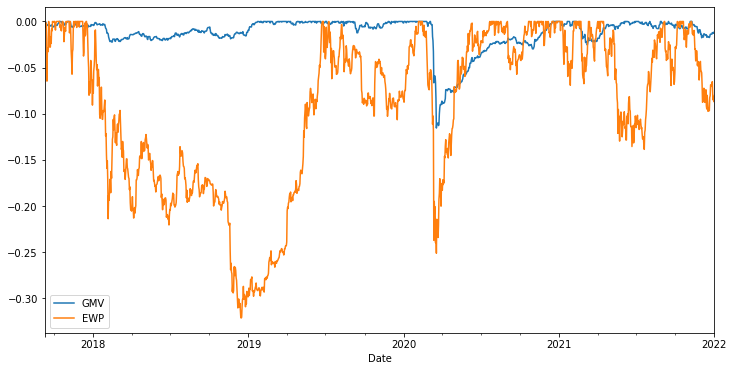

In [74]:
print(f'Ret Ann GMV Portfolio: {annualize_rets(gmv_pr, 252).round(3)} | Ret Ann EW Portfolio: {annualize_rets(ewp_r, 252).round(3)}')
print(f'Vol GMV Portfolio: {portfolio_vol(weights_gmv, cov).round(3)} | Vol EW Portfolio: {portfolio_vol(ewp, cov).round(3)}')
print(f'Sharpe Ratio GMV Portfolio: {(gmv_pr.mean().round(3)-0.0333)/portfolio_vol(weights_gmv, cov)} | Sharpe Ratio EW Portfolio: {(ewp_r.mean().round(3)-0.0333)/portfolio_vol(ewp, cov)}')

drawdown_df = pd.concat([drawdown(gmv_pr)[['Drawdown']], drawdown(ewp_r)[['Drawdown']]], axis=1)
drawdown_df.columns = ['GMV', 'EWP']
drawdown_df.plot(figsize=(12, 6));

## Pregunta 3

In [75]:
wp1 = np.array([0.6, 0.4, 0, 0])
wp2 = np.array([0.6, 0.2, 0.2, 0])
wp3 = np.array([0.5, 0.2, 0.2, 0.1])
wp4 = np.array([0.55, 0.2, 0.2, 0.05])

In [76]:
rp1 = portfolio_return(wp1, returns.T)
ann_rp1 = annualize_rets(rp1, 252)
vol_p1 = portfolio_vol(wp1, cov)
sp1 = (rp1.mean() - 0.0333)/vol_p1
mdd1 = drawdown(rp1).Drawdown.min()

rp2 = portfolio_return(wp2, returns.T)
ann_rp2 = annualize_rets(rp2, 252)
vol_p2 = portfolio_vol(wp2, cov)
sp2 = (rp2.mean() - 0.0333)/vol_p2
mdd2 = drawdown(rp2).Drawdown.min()

rp3 = portfolio_return(wp3, returns.T)
ann_rp3 = annualize_rets(rp3, 252)
vol_p3 = portfolio_vol(wp3, cov)
sp3 = (rp3.mean() - 0.0333)/vol_p3
mdd3 = drawdown(rp3).Drawdown.min()

rp4 = portfolio_return(wp4, returns.T)
ann_rp4 = annualize_rets(rp4, 252)
vol_p4 = portfolio_vol(wp4, cov)
sp4 = (rp4.mean() - 0.0333)/vol_p4
mdd4 = drawdown(rp4).Drawdown.min()

comparativa = pd.DataFrame({
    'Ann Ret': [ann_rp1, ann_rp2, ann_rp3, ann_rp4],
    'SR': [sp1, sp2, sp3, sp4],
    'Std': [vol_p1, vol_p2, vol_p3, vol_p4],
    'Max DD': [mdd1, mdd2, mdd3, mdd4]
}, index = ['P1', 'P2', 'P3', 'P4'])

comparativa

,Ann Ret,SR,Std,Max DD
P1,0.086164,-5.115251,0.006442,-0.217170
P2,0.084267,-4.965463,0.006637,-0.248102
P3,0.135194,-4.290288,0.007638,-0.244570
P4,0.110027,-4.793178,0.006856,-0.245578
